# Estimating precipitation rates and their changes from water vapor convergence

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from IPython.display import display
%matplotlib inline
plt.rcParams.update({'font.size': 18})#increase font size

# for calculating estimated condensation rate
import microphysics_functions as micro
from functions_mpas import *

In [2]:
pth='/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/'
list_of_exps = ['minus4K','CTL','plus4K'] #'minus4K'
expLabels = {
    'CTL': 'CTL',
    'plus4K' : 'plus4K',
    'minus4K':'minus4K',
    '30km' : '30 km',
    '15km' : '15 km',
    'TC_3km' : '3 km',
    'CTL/120km' : 'CTL (120 km)',
    'HOMO_RAD/120km' : 'HOMO_RAD (120 km)',
    'HOMO_RAD/120km_from_restart' : 'HOMO_RAD_rst',
    'HOMO_RAD/120km_online': 'HOMO_RAD_online'
}
nexps = len(list_of_exps)

#define constants
Rearth = 6379.0e3
G = 9.81

In [3]:
#increase font size
plt.rcParams.update({'font.size': 12})

lineColors = {
    'minus4K':'tab:blue',
    'CTL':'gray',
    'plus4K':'red',
    'CTL/120km':'black',
    'HOMO_RAD/120km':'red',
    'HOMO_RAD/120km_online':'tab:orange',
    'HOMO_RAD/120km_from_restart' : 'tab:blue'}

varsInfo = {
    'qv': {'factor': 1e3, 'label': 'water vapor\n mixing ratio\n (g kg$^{-1}$)'},
    'qv_w+': {'factor': 1e3, 'label': '(w+) water vapor\n mixing ratio\n (g kg$^{-1}$)'},
    'w+': {'factor':1,'label':'vertical wind (m s$^{-1}$)'},
    'qvs' : {'factor':1e3,'label':'saturated specific humidity (g kg$^{-1}$)'},
    'pr' : {'factor':24,'label':'rainfall rate (mm day$^{-1}$)'},
    'pr_resolved' : {'factor':24,'label':'res. rainfall rate (mm day$^{-1}$)'},
    'pr_from_qvflux' : {'factor':86400.0*1000.0,'label':'parametric rainfall rate (mm day$^{-1})'},
    'condensation_rate_vint': {'factor':3600.0,'label':'COND'},
    'PE':{'factor':1.0,'label':'precipitation efficiency'},
    'LSPE':{'factor':1.0,'label':'large-scale precipitation efficiency'},
    'VI':{'factor':1.0,'label':'VI'},
    'CHI_TE': {'factor':1.0,'label':r'$\chi$'},
    'MPI_VMAX': {'factor':1.0,'label':'MPI (m s$^{-1}$)'},
    'SHRM':{'factor':1.0,'label':'200-850 hPa shear magnitude (m s$^{-1}$)'},
    'GPI_Emanuel':{'factor':86400.0,'label':'GPI'},
    'absVOR850':{'factor':1.0e3,'label':'850-hPa absolute vorticity (10$^{-3}$ s$^{-1}$)'},
    'CHI_E':{'factor':1.0,'label':r'$\chi$'},
}

vars2plt = ['condensation_rate_vint','PE','pr_resolved','pr','w+','qvs']# ['streamFunction_vavg','pr','wa100-300','energyFlux']
list_of_exps=['minus4K','CTL','plus4K']
nexps=len(list_of_exps)

In [36]:
def get_largescale_pe(expName):
    fname=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname).sel(lat=slice(-10,35),time=slice('2000-05-01','2000-10-30'))
    # needed: qv, qc, qr, qi, qg, qs, u, v, and dry air density
    qc = ds.qc+ds.qr+ds.qi+ds.qg+ds.qs
    qv = ds.qv
    uwind = ds.uReconstructZonal
    vwind = ds.uReconstructMeridional
    wwind = ds.w
    rhod = ds.rhod
    # calculate dz
    level=ds.level
    dz = xr.DataArray(np.gradient(level),coords=level.coords,dims=level.dims)
    del(ds)
    
    #also needed: water vapor flux and surface rainfall rate
    fname=pth+expName+'/TC_3km/latlon/radFluxes_r360x180.nc'
    Qwve = xr.open_dataset(fname).sel(lat=slice(-10,35),time=slice('2000-05-01','2000-10-30')).qfx.mean('lon').mean('time')
    fname=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
    pr = xr.open_dataset(fname).sel(lat=slice(-10,35),time=slice('2000-05-01','2000-10-30')).pr.mean('lon').mean('time') * (1.0/3600.0) # convert from mm/h to kg * m2 / s
    
    # get dqvdt
    print('Qwvt...')
    qv_vint = (qv*rhod*dz).sum('level')
    Qwvt = -1.0*qv_vint.diff('time').mean('lon').mean('time')/(6.0*60.0*60.0) # data is six hourly

    # next get the condensate rate of change
    print('condensate...')
    qc_vint = (qc*rhod*dz).sum('level')
    qc_t = -1.0*qc_vint.diff('time').mean('lon').mean('time')/(6.0*60.0*60.0) # data is six hourly

    # get water vapor convergence
    print('Qwvf...')
    # #multiply uwind and vwind by qv
    # uwind_qv = uwind*qv
    # vwind_qv = vwind*qv
    # wwind_qv = wwind*qv
    # #compute divergence using the Bluestein approximation
    # #dv = Dv/Dy + Du/Dx -(v/a)*tan(phi)
    lat = np.radians(uwind.lat)
    lon = np.radians(uwind.lon)
    a = 6378.0e3
    # dudx = np.gradient(uwind_qv,lon*a,axis=2)#uwnd.diff('lon')/(a*xr.ufuncs.cos(uwnd.lat))
    # del(uwind_qv)
    # dvdy = np.gradient(vwind_qv,lat*a,axis=1)#vwnd.diff('lat')/a
    # # vertical derivative
    # dwdz = np.gradient(wwind_qv,level,axis=-1)
    # dumvar = (dudx+dvdy+dwdz)-(vwind_qv*np.tan(lat)/a)
    # del(vwind_qv,wwind_qv,dudx,dvdy,dwdz)
    # # vertical integration
    # Qwvf = (dumvar*rhod*dz).sum('level').mean('lon').mean('time')
    dumvar = (uwind*np.gradient(qv,lon*a,axis=2))+(vwind*np.gradient(qv,lat*a,axis=1))+(wwind*(np.gradient(qv,level,axis=3)))
    Qwvf = (dumvar*rhod*dz).sum('level').mean('lon').mean('time')

    # lastly, get the convergence of hydrometeors
    #multiply uwind and vwind by qc
    # uwind_qc = uwind*qc
    # vwind_qc = vwind*qc
    # wwind_qc = wwind*qc
    # #compute divergence using the Bluestein approximation
    # #dv = Dv/Dy + Du/Dx -(v/a)*tan(phi)
    # dudx = np.gradient(uwind_qc,lon*a,axis=2)#uwnd.diff('lon')/(a*xr.ufuncs.cos(uwnd.lat))
    # del(uwind_qc,uwind)
    # dvdy = np.gradient(vwind_qc,lat*a,axis=1)#vwnd.diff('lat')/a
    # # vertical derivative
    # dwdz = np.gradient(wwind_qc,level,axis=-1)
    # dumvar = (dudx+dvdy+dwdz)-(vwind_qc*np.tan(lat)/a)
    # del(vwind_qc,wwind_qc,dudx,dvdy,dwdz)
    dumvar = (uwind*np.gradient(qc,lon*a,axis=2))+(vwind*np.gradient(qc,lat*a,axis=1))+(wwind*(np.gradient(qc,level,axis=3)))
    # vertical integration
    conv_qc = (dumvar*rhod*dz).sum('level').mean('lon').mean('time')
    Qcm = qc_t+conv_qc

    print('adding all together...')
    # now calculate the precip efficiency
    # den = (np.sign(Qwvt)*Qwvt) + \
    #         (np.sign(Qwvf)*Qwvf) + \
    #         (np.sign(Qwve)*Qwve) + \
    #         (np.sign(Qcm)*Qcm)
    den = (-Qwvt-Qwvf+Qwve-Qcm)
    fig=plt.figure()
    plt.plot(np.degrees(lat),den)
    # plt.plot(np.degrees(lat),Qwve)
    # plt.plot(np.degrees(lat),Qwvt)
    # plt.plot(np.degrees(lat),Qcm)
    plt.plot(np.degrees(lat),pr)
    plt.title(expName)
    # plt.legend(['Qwvf','Qwve','Qwvt','Qcm','pr'])
    display(fig)
    plt.close()

    return pr/den

In [ ]:
plt.figure()
for expName in ['minus4K','CTL','plus4K']:
    precipEff = get_largescale_pe(expName)
    print(precipEff.max())
    # print((precipEff*np.cos(np.radians(precipEff.lat))).mean())
    plt.plot(precipEff.lat,precipEff,color=lineColors[expName])
# plt.ylim([0.,1.0])

In [37]:
import os

def read_zonal_mean_time_mean_quantities(list_of_exps,vars2read,levels):
    savedVars = {}
    
    for j in range(len(vars2read)):
        fig,axis=plt.subplots(figsize=(7,3))
        varName = vars2read[j]
        print(varName)
        out = {}
        for i in np.arange(nexps):
            expName = list_of_exps[i]
            level = levels[expName]
        
            # read in model fields
            fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
            ds = xr.open_dataset(fname3d).sel(lat=slice(-10,35)).squeeze()
            #print(xr.open_dataset(fname3d).pressure.sel(lat=0,lon=0,method='nearest').values)
            #continue
            if (varName == 'pr_from_qvflux'):
                fname=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
                ds = xr.open_dataset(fname).sel(lat=slice(-10,35))
                w = ds.w.sel(level=level,method='nearest')
                qvs = RSLF(ds.pressure.sel(level=level,method='nearest'),ds.temperature.sel(level=level,method='nearest'))
                w = w.where(w>0,0.0)
                fOut = pth+expName+'/TC_3km/latlon/LSPE_nosgn.nc'
                if os.path.exists(fOut):
                    ep = xr.open_dataset(fOut)['LSPE']
                ds[varName] = (0.0012*ep*qvs*w).mean('time')
            elif (varName == 'w+'):
                fname=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
                ds = xr.open_dataset(fname).sel(lat=slice(-10,35))
                w = ds.w.sel(level=level,method='nearest')
                w = w.where(w>0,0.0)
                ds[varName] = w.mean('time')
            elif (varName == 'qvs'):
                # calculate the same way its calculated online
                fname=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
                ds = xr.open_dataset(fname).sel(lat=slice(-10,35))
                qvs = RSLF(ds.pressure.sel(level=level,method='nearest'),ds.temperature.sel(level=level,method='nearest'))
                # we need qvs only where w+ is positive
                w = ds.w.sel(level=level,method='nearest')
                qvs = qvs.where(w>0)
                ds[varName] = qvs.mean('time')            
            elif (varName == 'condensation_rate_vint') | (varName == 'PE'):
                fname=pth+expName+'/TC_3km/latlon/condensation_rate_r360x180.nc'
                ds = xr.open_dataset(fname).sel(lat=slice(-10,35))
                if (varName == 'PE'):
                    fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                    pr = xr.open_dataset(fname2d).pr.sel(lat=slice(-10,35)).mean('time').mean('lon')
                    ds[varName] = (ds.condensation_rate.mean('time').mean('lon')/(pr/3600.0))
                else:
                    ds[varName] = ds.condensation_rate.mean('time')
            elif (varName == 'pr'):
                fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname2d).sel(lat=slice(-10,35))
                ds[varName] = ds[varName].mean('time')
            elif (varName == 'pr_resolved'):
                fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname2d).sel(lat=slice(-10,35))
                ds[varName] = (ds.pr-ds.prc).mean('time') 
            elif (varName == 'GPI_Emanuel'):
                print('calculating from the time mean conditions')
                fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname2d).sel(lat=slice(-10,35))
                MPI = ds.MPI_VMAX-35.0
                MPI_tm = MPI.where(MPI>0.0,0.0).mean('time')
                CHI = ds.CHI_E.mean('time')
                VOR = ds.VOR850.mean('time')
                VOR = VOR+(2.0*7.292e-5*np.sin(np.radians(ds.lat)))
                SHR = (ds.SHRM+25.0).mean('time')
                GPI = (np.fabs(VOR)**3.0)*(CHI**(-4.0/3.0))*(MPI_tm**2.0)/(SHR)**4.0
                # multiply by area 
                dlat=ds.lat[-1]-ds.lat[-2]
                dlon=ds.lon[1]-ds.lon[0]
                ds[varName] = GPI.sum('lon')*2.0*np.pi*np.cos(np.radians(ds.lat))*np.radians(dlat)*np.radians(dlon)*Rearth**2.0
                print(ds[varName].sum())
            elif (varName =='absVOR850'):
                fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname2d).sel(lat=slice(-10,35))
                VOR = ds.VOR850
                VOR = VOR+(2.0*7.292e-5*np.sin(np.radians(ds.lat)))
                ds[varName] = VOR.mean('time')
            elif (varName == 'MPI_VMAX'):
                fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname2d).sel(lat=slice(-10,35))
                MPI = ds.MPI_VMAX-35.0
                ds[varName] = MPI.where(MPI>0.0,0.0).mean('time')
            elif (varName == 'SHRM'):
                fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname2d).sel(lat=slice(-10,35))
                SHR = ds.SHRM+25.0
                ds[varName]=SHR.mean('time')
            elif (varName == 'LSPE'):
                fOut = pth+expName+'/TC_3km/latlon/LSPE_nosgn.nc'
                if os.path.exists(fOut):
                    ds[varName] = xr.open_dataset(fOut)['LSPE']
                else:
                    ds[varName] = get_largescale_pe(expName)
                    LSPE.to_netcdf(fOut)
            elif (varName == 'qv_w+'):
                fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
                ds = xr.open_dataset(fname3d).sel(lat=slice(-10,35))
                qv = ds.qv.sel(level=level,method='nearest')
                w = ds.w.sel(level=level,method='nearest')
                ds[varName] = qv.where(w>0).mean('time')                
            else:
                fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
                ds = xr.open_dataset(fname3d).sel(lat=slice(-10,35))
                ds[varName] = ds[varName].sel(level=level,method='nearest').mean('time')
            ds[varName] = ds[varName]*varsInfo[varName]['factor']
    
            # print(ds[varName].sel(lat=0,method='nearest').mean('lon'))
    
            if (varName == 'streamFunction_vavg') | (varName == 'vh') | (varName == 'wa100-300') | \
               (varName == 'energyFlux') | (varName == 'totalEnergyForcing') | (varName == 'GPI_Emanuel')|\
               (varName == 'PE') | (varName == 'LSPE'):
                axis.plot(ds.lat,ds[varName],color=lineColors[expName],linewidth=2)
                out[expName]=ds[varName]
            else:
                axis.plot(ds.lat,ds[varName].mean('lon').squeeze(),color=lineColors[expName],linewidth=2)
                out[expName]=ds[varName].mean('lon').squeeze()

            del(ds)
    
        savedVars[varName]=out
        axis.set_ylabel(varsInfo[varName]['label'])
        axis.grid(True)
        if (varName == 'VI'):
            axis.set_yscale('log')
        # axis.axvline(x=2.5,color='k')
    
        # specify y-tick marks
        axis.set_xticks([-10,0,10,20,30,40])
        axis.set_xticklabels(['10S','0','10N','20N','30N','40N'])
        # ax[-1].set_xlim([-10,40])
        axis.set_xlabel('latitude')
        # add legend
        axis.legend(list_of_exps)
        # plt.savefig('./Figures/lat_profiles_mpas_aqua_sstmax10N_ASD_GPI.jpeg',dpi=600,bbox_inches='tight')

    return savedVars

### Estimate changes in pr from pr ~ ep * w * qvs

In [7]:
def calc_dln(expName1,expName2,gpiVars,vars2read):
    out = {}
    for varName in vars2read:
        var1 = gpiVars[varName][expName1]
        var2 = gpiVars[varName][expName2]

        # factors
        if (varName == 'absVOR850'):
            diff = 3.0*(np.log(np.fabs(var1))-np.log(np.fabs(var2)))
        elif (varName == 'CHI_E'):
            diff = -4/3.*(np.log(var1)-np.log(var2))
        elif (varName == 'MPI_VMAX'):
            # var1 = var1-35.0
            # var1 = var1.where(var1>0)
            # var2 = var2-35.0
            # var2 = var2.where(var2>0)
            diff = 2.0*(np.log(var1)-np.log(var2))
        elif (varName == 'SHRM'):
            # var1=var1+25.0
            # var2=var2+25.0
            diff = -4.0*(np.log(var1)-np.log(var2))
        elif (varName == 'GPI_Emanuel'):
            diff = np.log(var1)-np.log(var2)+(np.log(GPI_factors[expName1])-np.log(GPI_factors[expName2]))
        else:
            diff = np.log(var1)-np.log(var2)

        out[varName]=diff
    return out

LSPE
Qwvt...
condensate...
Qwvf...
adding all together...


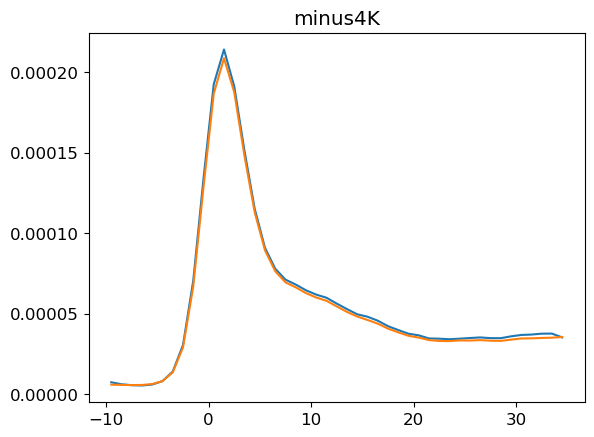

Qwvt...
condensate...
Qwvf...
adding all together...


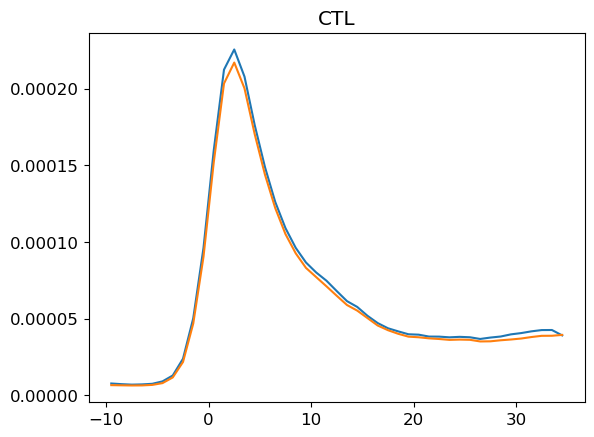

Qwvt...
condensate...
Qwvf...
adding all together...


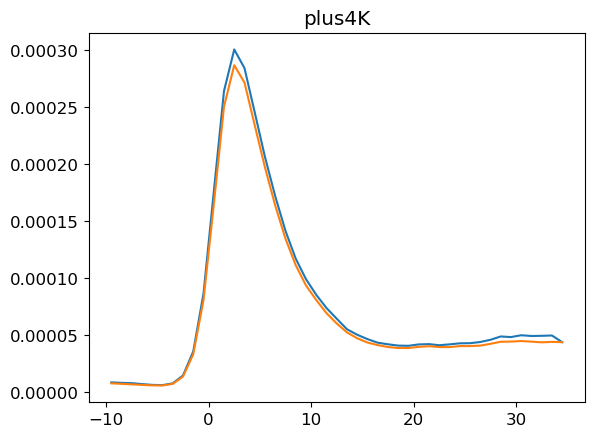

pr
qvs
w+
pr_from_qvflux


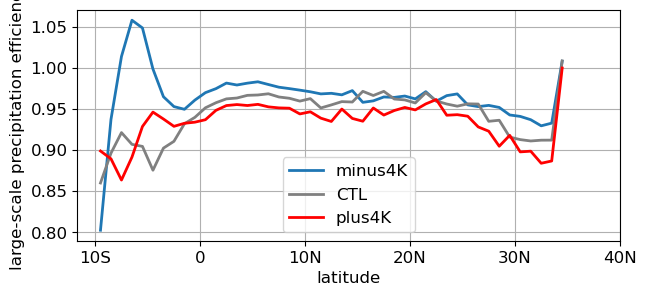

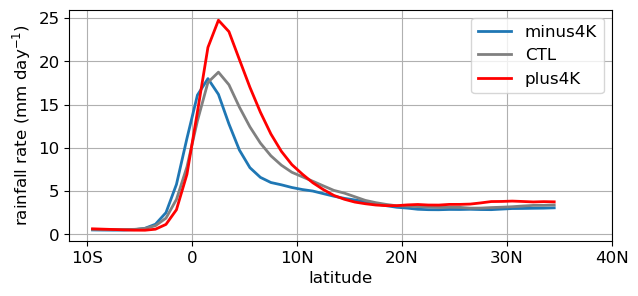

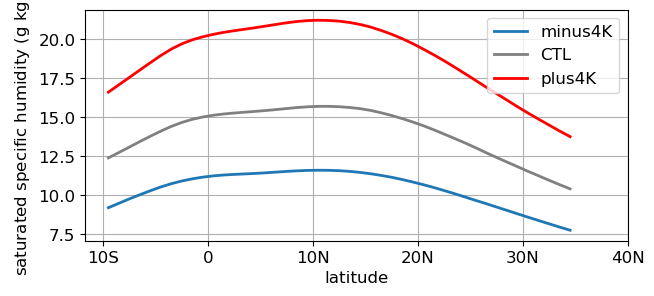

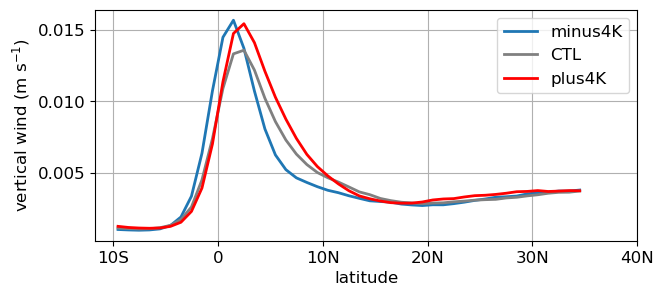

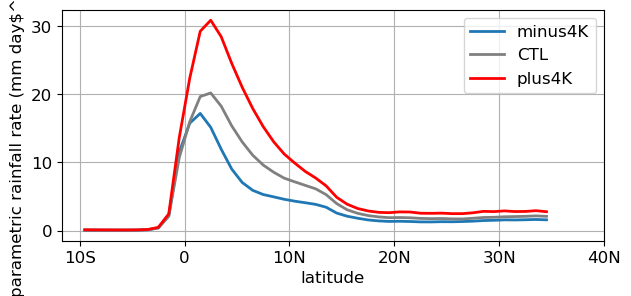

In [38]:
vars2read = ['LSPE','pr','qvs','w+','pr_from_qvflux']
# levels = {
#     'minus4K':1999.0734,
#     'CTL':1271.0596,
#     'plus4K':1053.876}
levels = {
    'minus4K' : 1250.0,
    'CTL': 1250.0,
    'plus4K' : 1250.0,
}
savedVars = read_zonal_mean_time_mean_quantities(list_of_exps,vars2read,levels)

In [27]:
scalingFactors = {
    'minus4K' : 0.9,
    'CTL':0.78,
    'plus4K':0.67,
}

# color-blind friendly palette taken from https://gist.github.com/thriveth/8560036
colors = {
    'qvs': '#ff7f00',
    'pr':  '#a65628',
    'w+':  '#4daf4a',
    'LSPE': '#984ea3',
}

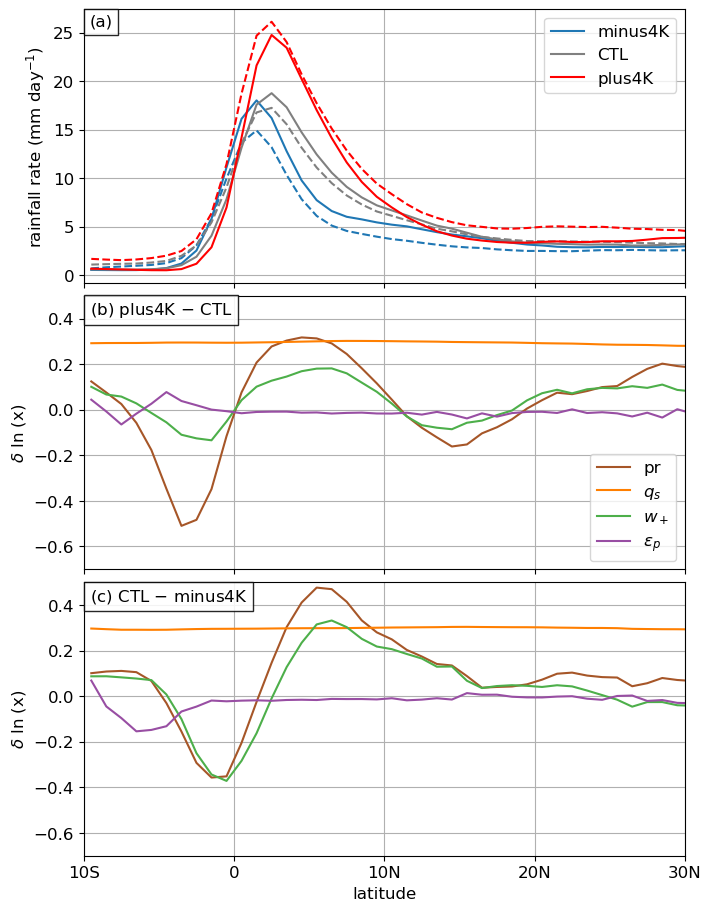

In [40]:
# First plot pr and pr_from qvflux to show agreement
fig, ax = plt.subplots(nrows=3,figsize=(7,9),sharex=True,constrained_layout=True)

for expName in list_of_exps:
    ax[0].plot(savedVars['pr'][expName].lat,savedVars['pr'][expName],color=lineColors[expName],label=expName)
    pr_from_qvflux = 1e-3*savedVars['w+'][expName]*savedVars['qvs'][expName]*savedVars['LSPE'][expName]*86400.0 #*cond[expName]/(pr[expName]/24.0)*86400.0 #
    # pr_from_qvflux = savedVars['pr_from_qvflux'][expName] #*cond[expName]/(pr[expName]/24.0)*86400.0 #
    ax[0].plot(pr_from_qvflux.lat,pr_from_qvflux,color=lineColors[expName],linestyle='dashed')

ax[0].legend()
ax[0].grid(True)

#calculate and plot changes
# ----- plus4K minus CTL
expName1='plus4K'
expName2='CTL'
vars2read = ['pr','qvs','w+','LSPE']
diffpr = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in vars2read:
    ax[1].plot(diffpr[varName].lat,diffpr[varName],color=colors[varName])
# ax[1].axhline(y=(np.log(scalingFactors[expName1])-np.log(scalingFactors[expName2])),color=colors['ep'],linestyle='dashed')
ax[1].grid(True)

#calculate and plot changes
# ----- CTL minus minus4K
expName1='CTL'
expName2='minus4K'
# vars2read = ['pr','LSPE','qvs','w+']
diffpr = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in vars2read:
    ax[2].plot(diffpr[varName].lat,diffpr[varName],color=colors[varName])
# ax[2].axhline(y=(np.log(scalingFactors[expName1])-np.log(scalingFactors[expName2])),color=colors['ep'],linestyle='dashed')
ax[2].grid(True)
ax[2].set_xlabel('latitude')

ax[0].set_ylabel('rainfall rate (mm day$^{-1}$)')
ax[1].set_ylabel(r'$\delta$ ln (x)')
ax[2].set_ylabel(r'$\delta$ ln (x)')

# add legend
ax[1].legend(['pr',r'$q_s$',r'$w_+$',r'$\epsilon_p$'])

# control y axes
ax[1].set_ylim([-0.7,0.5])
ax[2].set_ylim([-0.7,0.5])

# specify y-tick marks
ax[-1].set_xticks([-10,0,10,20,30])
ax[-1].set_xticklabels(['10S','0','10N','20N','30N'])
ax[-1].set_xlim([-10,30])

# add panel labels
ax[0].text(0.01, 0.982,'(a)',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax[0].transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 
# add panel labels
ax[1].text(0.01, 0.982,'(b) plus4K $-$ CTL',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax[1].transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 
# add panel labels
ax[2].text(0.01, 0.982,'(c) CTL $-$ minus4K',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax[2].transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85))
plt.savefig('./Figures/lat_profiles_mpas_aqua_sstmax10N_ASD_dln_pr.jpeg',dpi=600,bbox_inches='tight')

### Estimate changes in GPI and VI

In [ ]:
vars2read = ['absVOR850','CHI_E','MPI_VMAX','SHRM','GPI_Emanuel','CHI_TE','VI']
savedVars = read_zonal_mean_time_mean_quantities(list_of_exps,vars2read)

In [ ]:
fig, ax = plt.subplots(nrows=2,figsize=(7,6),sharex=True,constrained_layout=True)

# color-blind friendly palette taken from https://gist.github.com/thriveth/8560036
colors = {
    'SHRM': '#ff7f00',
    'GPI_Emanuel':  '#a65628',
    'absVOR850':   '#f781bf',
    'CHI_E':  '#4daf4a',
    'MPI_VMAX': '#984ea3'
}

GPI_factors = {
    'minus4K': 111/0.00390038,#3.95,
    'CTL': 147/0.0035649,#5.74,
    'plus4K': 137/0.00392327,#4.67,
}

varLabels = {
    'GPI_Emanuel':'GPI',
    'absVOR850':r'$\eta$',
    'CHI_E':r'$\chi$',
    'MPI_VMAX':r'$u_{PI}$',
    'SHRM':r'$u_{shear}$',
}

vars2read=['GPI_Emanuel','absVOR850','CHI_E','MPI_VMAX','SHRM']
# ----- CTL minus plus4K
expName1='plus4K'
expName2='CTL'
diffGPI = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in vars2read:
    # if (varName == 'MPI_VMAX'):
    #     diffGPI[varName]=diffGPI[varName]+np.log(GPI_factors[expName1])-np.log(GPI_factors[expName2])
    ax[0].plot(diffGPI[varName].lat,diffGPI[varName],color=colors[varName],label=varLabels[varName])
# ax[0].axhline(y=(np.log(GPI_factors[expName1])-np.log(GPI_factors[expName2])),color='gray',linestyle='dashed')

# ----- CTL minus plus4K
expName1='CTL'
expName2='minus4K'
diffGPI = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in vars2read:
    # if (varName == 'MPI_VMAX'):
    #     diffGPI[varName]=diffGPI[varName]+np.log(GPI_factors[expName1])-np.log(GPI_factors[expName2])
    ax[1].plot(diffGPI[varName].lat,diffGPI[varName],color=colors[varName])
# ax[1].axhline(y=(np.log(GPI_factors[expName1])-np.log(GPI_factors[expName2])),color='gray',linestyle='dashed')

# ax[0].legend(['GPI',r'$\eta$',r'$\chi$',r'$u_{PI}$',r'$u_{shear}$'],loc='upper right')

ax[0].grid(True)
ax[1].grid(True)
ax[1].set_xlabel('latitude')
ax[0].set_ylabel(r'$\delta$ ln (x)')
ax[1].set_ylabel(r'$\delta$ ln (x)')

# global legend
# so far so good, now the trick to add the legend at the top 
lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)
fig.legend(lines, labels, bbox_to_anchor=(0.2, 1.02, 0.7, 0.5), loc=3, ncol=5, mode="expand", borderaxespad=0.,fontsize=10)

# add panel labels
ax[0].text(0.01, 0.982,'(a) plus4K $-$ CTL',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax[0].transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 
# add panel labels
ax[1].text(0.01, 0.982,'(b) CTL $-$ minus4K',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax[1].transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85))
plt.savefig('./Figures/lat_profiles_mpas_aqua_sstmax10N_ASD_dln_GPI.jpeg',dpi=600,bbox_inches='tight')

Ventilation index

In [ ]:
fig, ax = plt.subplots(nrows=2,figsize=(7,6),sharex=True,constrained_layout=True)

# color-blind friendly palette taken from https://gist.github.com/thriveth/8560036
colors = {
    'SHRM': '#ff7f00',
    'VI':  '#a65628',
    'CHI_TE':  '#4daf4a',
    'MPI_VMAX': '#984ea3'
}

vars2read=['VI','CHI_TE','MPI_VMAX','SHRM']

# ----- CTL minus plus4K
expName1='plus4K'
expName2='CTL'
diffVI = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in ['VI','CHI_TE','MPI_VMAX','SHRM']:
    ax[0].plot(diffVI[varName].lat,diffVI[varName],color=colors[varName])
# ax[0].axhline(y=(np.log(GPI_factors[expName1])-np.log(GPI_factors[expName2])),color='gray',linestyle='dashed')

# ----- CTL minus plus4K
expName1='CTL'
expName2='minus4K'
diffVI = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in ['VI','CHI_TE','MPI_VMAX','SHRM']:
    ax[1].plot(diffVI[varName].lat,diffVI[varName],color=colors[varName])
# ax[1].axhline(y=(np.log(GPI_factors[expName1])-np.log(GPI_factors[expName2])),color='gray',linestyle='dashed')

ax[0].legend(['VI',r'$\chi_{TE}$',r'$u_{PI}$',r'$u_{shear}$'],loc='upper right')
ax[0].grid(True)
ax[1].grid(True)
ax[1].set_xlabel('latitude')
ax[0].set_ylabel(r'$\delta$ ln (x)')
ax[1].set_ylabel(r'$\delta$ ln (x)')

# add panel labels
ax[0].text(0.01, 0.982,'(a) plus4K $-$ CTL',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax[0].transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 
# add panel labels
ax[1].text(0.01, 0.982,'(b) CTL $-$ minus4K',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax[1].transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85))
plt.savefig('./Figures/lat_profiles_mpas_aqua_sstmax10N_ASD_dln_VI.jpeg',dpi=600,bbox_inches='tight')

### Precipitation

In [ ]:
vars2read = ['pr','pr_resolved','qvs','w+']
savedVars = read_zonal_mean_time_mean_quantities(list_of_exps,vars2read)

In [ ]:
# First plot pr and pr_from qvflux to show agreement
fig, ax = plt.subplots(nrows=3,figsize=(7,9),sharex=True,constrained_layout=True)

for expName in list_of_exps:
    ax[0].plot(savedVars['pr'][expName].lat,savedVars['pr'][expName],color=lineColors[expName],label=expName)
    pr_from_qvflux = (0.0012)*savedVars['w+'][expName]*savedVars['qvs'][expName]*scalingFactors[expName]*86400.0 #*cond[expName]/(pr[expName]/24.0)*86400.0 #
    ax[0].plot(pr_from_qvflux.lat,pr_from_qvflux,color=lineColors[expName],linestyle='dashed')

ax[0].legend()
ax[0].grid(True)

#calculate and plot changes
# ----- CTL minus plus4K
expName1='plus4K'
expName2='CTL'
vars2read = ['pr','qvs','w+']
diffpr = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in vars2read:
    ax[1].plot(diffpr[varName].lat,diffpr[varName],color=colors[varName])
ax[1].axhline(y=(np.log(scalingFactors[expName1])-np.log(scalingFactors[expName2])),color=colors['ep'],linestyle='dashed')

#calculate and plot changes
# ----- CTL minus plus4K
expName1='plus4K'
expName2='CTL'
vars2read = ['pr','qvs','w+']
diffpr = calc_dln(expName1,expName2,savedVars,vars2read)
for varName in vars2read:
    ax[1].plot(diffpr[varName].lat,diffpr[varName],color=colors[varName])
ax[1].axhline(y=(np.log(scalingFactors[expName1])-np.log(scalingFactors[expName2])),color=colors['ep'],linestyle='dashed')
